In [1]:
!conda env list

# conda environments:
#
base                     /home/reza_soleymanifar/miniconda3
alpaca-rl             *  /home/reza_soleymanifar/miniconda3/envs/alpaca-rl
sentrl                   /home/reza_soleymanifar/miniconda3/envs/sentrl
                         /home/reza_soleymanifar/repos/SentRL/.conda



In [2]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()
djs = [stock['symbol'] for stock in list(stock_data.get_stocks_by_index('DOW JONES'))]

In [3]:
'Dow Jones' in stock_data.get_all_indices()

False

In [4]:
stock_data.get_all_indices()

['IBEX 35',
 'OMX Helsinki 25',
 'S&P 100',
 'AEX',
 'SDAX',
 'CAC 40',
 'Switzerland 20',
 'DOW JONES',
 'NASDAQ 100',
 'MDAX',
 'DAX',
 'EURO STOXX 50',
 'TECDAX',
 'OMX Stockholm 30',
 'BEL 20',
 'MOEX',
 'S&P 600',
 'CAC Mid 60',
 'CDAX',
 'S&P 500',
 'FTSE 100']

In [5]:
djs

['MMM',
 'AXP',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'GS',
 'HD',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'NKE',
 'MRK',
 'MSFT',
 'PG',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WMT',
 'WBA',
 'DIS',
 'AMGN',
 'HON',
 'CRM',
 'DOW']

Add technical indicators

In [6]:
def indicators(df):
# trend
    df['macd'] = ta.trend.macd(df['close'])
    df['cci'] = ta.trend.cci(high = df['high'], low= df['low'], close=df['close'])
# momentum
    df['rsi'] = ta.momentum.rsi(close = df['close']) 
    return df

In [7]:
def resample(df, interval):
    # relies on daily data having prices before and after trade hours, so forward filling works.
    map = {'1Min':'1T', '5Min':'5T', '15Min': '15T', '1H': '1H', '1D':'1D', '1W':'1W'}
    resampled = df.resample(map[interval]).ffill()
    return resampled

Read bars dataset from Alpaca API

In [18]:
import pandas as pd
from alpaca_trade_api.rest import REST
import os
import numpy as np
import exchange_calendars as ec
import ta

# Retrieve the historical bar data for AAPL during regular trading hours. exclude aftermarket data.

# Replace with your own API credentials
# API_KEY = 'PKYLYX8BR5Z6F0TIMX92'
# API_SECRET = 'ZWHycpjUN02eJw4bcx8dZvOAHnwY2gsUcUtEpTRX'
# BASE_URL = 'https://api.alpaca.markets'

API_KEY = os.environ['ALPACA_API_KEY']
API_SECRET = os.environ['ALPACA_API_SECRET']
BASE_URL = os.environ['ALPACA_BASE_URL']
PAPER_URL = os.environ['ALPACA_PAPER_URL']

# Create an instance of the REST API
api = REST(API_KEY, API_SECRET, PAPER_URL, api_version='v2')

interval = '15Min' # "1Min", "5Min", "15Min", "1H", "1D", "1W"
# interval = timedelta(minutes=1)
start = "2021-06-08"  # start time, min="2015-01-01"
end = "2021-06-08"  # End time, max=today's date
symbol = ['AAPL', 'MMM', 'AXP'] # symbols should trade in ET 

# Check if symbol trades in ET
pass

df = api.get_bars(djs, interval, start, end, adjustment='raw').df
df = df.tz_convert('America/New_York')

KeyError: 'ALPACA_PAPER_URL'

In [17]:
account_info = api.get_account()

APIError: request is not authorized

In [73]:
# If no price change in interval, API returns no row. handles missing intervals by forward filling.
df = pd.concat([indicators(resample(group[1], interval)) for group in df.groupby('symbol')], axis = 1)

In [74]:
# df = pd.concat([(resample(group[1], interval)) for group in df.groupby('symbol')])

In [75]:
nyse = ec.get_calendar("NYSE")
working_days = nyse.sessions_in_range(start, end).normalize()
# filter NYSE working days
df = df[df.index.floor('D').tz_localize(None).isin(working_days)]

# Filter NYSE trading hours
# all symbols must trade in NYSE hours
df = df[(pd.Timestamp("09:30:00").time() <= df.index.time) &\
         (df.index.time < pd.Timestamp("16:00:00").time())]

In [76]:
# groups =  df.groupby('symbol')
# groups.size().nunique() == 1

In [77]:
# any(df.isnull().any().values)

In [78]:
df = df.select_dtypes(include=np.number)
df.dropna(inplace=True)

In [79]:
prices = df['close']

In [81]:
prices

,close,close,close,close,close,close,close,close,close,close,...,close,close,close,close,close,close,close,close,close,close
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-08 09:30:00-04:00,126.6600,238.5425,164.2000,254.8958,239.5000,238.6300,53.985,107.4800,176.2101,68.92,...,73.1000,254.400,134.710,136.6800,157.0170,400.690,231.410,57.0950,53.6290,140.8500
2021-06-08 09:31:00-04:00,126.5300,238.6900,164.2900,255.5600,239.4000,238.7670,54.100,107.5100,176.1200,69.04,...,72.9853,254.670,134.390,136.5300,156.8700,399.960,231.180,57.0150,53.4545,140.8600
2021-06-08 09:32:00-04:00,126.5700,239.0600,164.2287,254.2900,239.0899,238.7757,54.110,107.4700,175.9600,68.80,...,72.9599,255.030,134.390,136.6400,156.8700,399.800,230.320,57.0703,53.6300,140.6500
2021-06-08 09:33:00-04:00,126.7850,238.4800,164.1100,254.6050,238.9500,239.3700,54.070,107.2817,176.1500,68.91,...,72.9350,254.790,134.380,136.5600,156.9800,399.530,230.700,57.0550,53.5600,140.7100
2021-06-08 09:34:00-04:00,127.1100,238.4200,164.2000,254.7500,238.3450,239.5650,54.085,107.1300,176.1800,68.85,...,72.8200,254.900,134.260,136.4900,156.8800,400.065,230.870,57.0500,53.5500,140.6045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09 15:55:00-04:00,127.1350,239.3900,164.0050,248.0400,234.8800,236.3200,54.030,107.8400,176.1600,68.92,...,73.9825,253.465,131.840,134.8450,154.9200,401.170,232.275,57.1600,53.4350,139.1850
2021-06-09 15:56:00-04:00,127.1450,239.5500,164.0700,248.1000,234.8100,236.3500,54.015,107.9400,176.1700,68.95,...,74.0300,253.430,131.880,134.8750,154.9375,401.185,232.280,57.1550,53.4500,139.2000
2021-06-09 15:57:00-04:00,127.1598,239.5700,164.0800,248.0800,234.7500,236.3200,54.018,107.8500,176.1300,68.89,...,74.0264,253.480,131.845,134.8600,154.9100,401.230,232.310,57.1550,53.4500,139.1600


In [80]:
df

,open,high,low,close,volume,trade_count,vwap,macd,cci,rsi,...,open,high,low,close,volume,trade_count,vwap,macd,cci,rsi
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-08 09:30:00-04:00,126.6200,126.775,126.5850,126.6600,1544654,7815,126.626592,-0.047424,-161.121449,32.862705,...,140.510,140.9000,140.42,140.8500,146268.0,528.0,140.561080,-0.036908,-70.434070,50.851108
2021-06-08 09:31:00-04:00,126.6609,126.670,126.4485,126.5300,536481,4139,126.527097,-0.062902,-208.248517,25.599687,...,140.810,140.8700,140.70,140.8600,17749.0,304.0,140.804045,-0.028681,-30.051205,51.239643
2021-06-08 09:32:00-04:00,126.5250,126.570,126.4500,126.5700,381851,3116,126.499365,-0.071121,-173.074776,30.676549,...,140.800,140.8400,140.64,140.6500,16821.0,262.0,140.757382,-0.038660,-78.110808,43.468336
2021-06-08 09:33:00-04:00,126.5700,126.890,126.5579,126.7850,470070,4495,126.719530,-0.059598,-31.617114,50.305336,...,140.650,140.7600,140.63,140.7100,12691.0,219.0,140.692476,-0.041251,-80.187725,45.988844
2021-06-08 09:34:00-04:00,126.7800,127.110,126.7619,127.1100,648836,6332,126.965050,-0.023966,119.600320,65.984422,...,140.720,140.7200,140.58,140.6045,14656.0,226.0,140.634728,-0.051228,-104.222623,42.408421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-09 15:55:00-04:00,127.1250,127.150,127.1100,127.1350,323667,2413,127.132157,0.015407,157.496099,67.744920,...,139.160,139.1950,139.15,139.1850,42455.0,560.0,139.173889,-0.036626,-42.490711,41.426248
2021-06-09 15:56:00-04:00,127.1360,127.175,127.1200,127.1450,328643,2465,127.154222,0.025347,148.014960,68.524831,...,139.185,139.2133,139.17,139.2000,49724.0,547.0,139.188454,-0.032078,9.482229,45.866689
2021-06-09 15:57:00-04:00,127.1450,127.160,127.1200,127.1598,283111,2035,127.139955,0.034026,128.344537,69.692821,...,139.210,139.2150,139.15,139.1600,43159.0,474.0,139.185045,-0.031341,-37.290393,37.666378


In [82]:
import pickle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(df)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Later on, you can load the scaler from the file like this:
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

features = scaler.transform(df)

In [83]:
features.shape

(780, 300)

Read news dataset from Alpaca API

In [115]:
def to_iso(time_stamp):
    return time_stamp.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2023-03-18')
# pulls maximum of 50 news within each delta interval
# smaller data means more requests sent (more intervals). If so be careful with Alpaca API request limit: 200/minute
delta = pd.Timedelta(hours=1)
news_df = pd.DataFrame(columns=['symbol', 'news', 'datetime'])
current_date = start_date

while current_date < end_date:
    end = min(end_date, current_date + delta)
    articles = api.get_news(symbol=dow_jones_symbols, start=to_iso(current_date), end=to_iso(end))
    news_df.to_csv('news')
    for symbol in dow_jones_symbols:
        for article in articles:
            if symbol in article.symbols:
                news = article.summary + article.headline
                datetime = article.created_at
                news_df = news_df.append({'symbol': symbol, 'news': news, 'datetime': datetime}, ignore_index=True)
    current_date = end

sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1beta1/news 3 more time(s)...
sleep 3 seconds and retrying htt

In [153]:
news = pd.read_csv('news')

In [154]:
news

,Unnamed: 0,symbol,news,datetime
0,0,AAPL,Tech stocks stood out in 2021 with their solid...,2022-01-01 15:25:38+00:00
1,1,NKE,Tech stocks stood out in 2021 with their solid...,2022-01-01 15:25:38+00:00
2,2,MSFT,Tech stocks stood out in 2021 with their solid...,2022-01-01 15:25:38+00:00
3,3,AAPL,Benzinga has examined the prospects for many i...,2022-01-01 16:52:52+00:00
4,4,AAPL,"Tesla, Inc. (NASDAQ: TSLA) bull Gene Munster, ...",2022-01-01 16:19:49+00:00
5,5,DIS,Benzinga has examined the prospects for many i...,2022-01-01 16:52:52+00:00
6,6,AAPL,Top 25 WallStreetBets Mentions for 2021,2022-01-01 17:31:24+00:00
7,7,MSFT,Top 25 WallStreetBets Mentions for 2021,2022-01-01 17:31:24+00:00
8,8,DIS,Top 25 WallStreetBets Mentions for 2021,2022-01-01 17:31:24+00:00
9,9,AAPL,"The Metaverse, which is touted to be the next ...",2022-01-01 18:38:26+00:00


In [89]:
news_df.to_csv('news')

In [80]:
api.get_news(symbol='MMM', start=start, end=end)

[]

In [71]:
news_df.iloc[0]

symbol                            MMM
summary                              
datetime    2021-06-07 09:27:34+00:00
Name: 0, dtype: object

In [67]:
news_df

,symbol,summary,datetime
0,MMM,,2021-06-07 09:27:34+00:00
1,AXP,Analysts have provided the following ratings f...,2021-06-07 15:57:37+00:00
2,AXP,"\n\n \n\nBefore 10 a.m. ET Monday, 296 stocks...",2021-06-07 14:14:31+00:00
3,AXP,,2021-06-07 14:03:13+00:00
4,AXP,\n\tWells Fargo boosted the price target for ...,2021-06-07 11:48:23+00:00
5,AXP,,2021-06-07 11:05:42+00:00
6,AAPL,Apple Inc. (NASDAQ: AAPL) kicked off its five-...,2021-06-07 22:43:55+00:00
7,AAPL,,2021-06-07 20:13:15+00:00
8,AAPL,\n,2021-06-07 18:49:06+00:00
9,AAPL,,2021-06-07 18:45:50+00:00


In [137]:
news = []
page_token = None

while True:
    response = api.get_news(symbol=symbol, start=start, end=end, limit=50, page_token=page_token)
    news += response
    if 'next_page_token' in response.keys():
        page_token = response['next_page_token']
    else:
        break

In [6]:
articles

[NewsV2({   'author': 'Benzinga Insights',
     'content': '',
     'created_at': '2023-03-17T17:35:16Z',
     'headline': "10 Information Technology Stocks Whale Activity In Today's "
                 'Session',
     'id': 31401775,
     'images': [   {   'size': 'large',
                       'url': 'https://cdn.benzinga.com/files/imagecache/2048x1536xUP/images/story/2023/options_image_532.jpeg'},
                   {   'size': 'small',
                       'url': 'https://cdn.benzinga.com/files/imagecache/1024x768xUP/images/story/2023/options_image_532.jpeg'},
                   {   'size': 'thumb',
                       'url': 'https://cdn.benzinga.com/files/imagecache/250x187xUP/images/story/2023/options_image_532.jpeg'}],
     'source': 'benzinga',
     'summary': ' ',
     'symbols': [   'AAPL',
                    'ADBE',
                    'AMD',
                    'CRM',
                    'FIS',
                    'MU',
                    'NVDA',
                   

In [800]:
df

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 09:00:00+00:00,118.880,118.94,118.88,118.94,1145,5,118.902052,AAPL
2015-12-01 09:15:00+00:00,118.770,118.77,118.77,118.77,200,1,118.770000,AAPL
2015-12-01 09:30:00+00:00,118.690,118.69,118.60,118.60,900,4,118.610000,AAPL
2015-12-01 09:45:00+00:00,118.640,118.65,118.64,118.65,3580,5,118.648883,AAPL
2015-12-01 10:00:00+00:00,118.650,118.65,118.55,118.55,1820,4,118.611538,AAPL
...,...,...,...,...,...,...,...,...
2021-06-08 22:45:00+00:00,126.700,126.74,126.68,126.73,12461,91,126.706332,AAPL
2021-06-08 23:00:00+00:00,126.725,126.76,126.71,126.71,8845,78,126.738951,AAPL
2021-06-08 23:15:00+00:00,126.720,126.76,126.72,126.76,7805,80,126.738487,AAPL


## price prediction

Preprocessing

In [801]:
import numpy as np

# Only keep the price info
df = df.loc[:, 'open':'close']

# #only keep numeric columns
# df = df.select_dtypes(include=np.number)

# Idea: concatenate data for past window_size intervals and feed to model
window_size = 1
# Create shifted versions of the DataFrame?
shifted_dfs = [df.shift(i) for i in range(window_size)]
# Concatenate shifted DataFrames
concatenated_df = pd.concat(shifted_dfs, axis=1)
# Add label to shifted dfs
concatenated_df['label'] = df['close'].shift(-1)
# Remove rows with NaN values
concatenated_df.dropna(inplace=True)
# Convert concatenated DataFrame to list of lists
y = concatenated_df['label'].values
X = concatenated_df.iloc[:, :-1].values

In [802]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=False)

# do not use scaler on whole X to avoid info from test bleed into trainig.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [803]:
from matplotlib import pyplot as plt

def compare(y, y_pred):
    plt.plot(y, color='red', marker = 'o', label = 'ground truth')
    plt.plot(y_pred, marker = 'o', label = 'prediction')
    for i in range(len(y_pred)):
        plt.axvline(i, color='r', linestyle='--', alpha = 0.1)
    plt.legend()
    plt.show()

Linear Regression

In [804]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# Fit the model to your data
model.fit(X_train, y_train)
y_pred_lin = model.predict(X_test)
print(mean_squared_error(y_test, y_pred_lin))

8.66743632585872


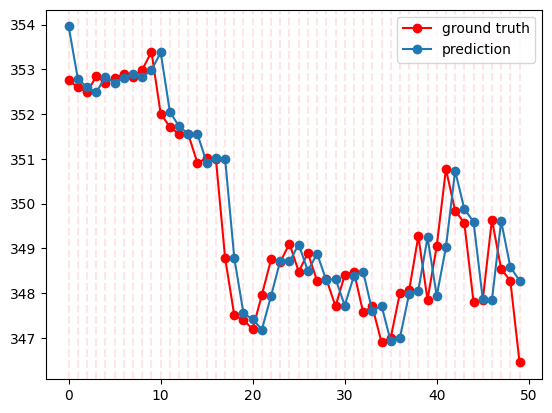

In [805]:
compare(y_test[1000:1050], y_pred_lin[1000:1050])

Random forest

In [806]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Fit the model to your data
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)
print(mean_squared_error(y_test, y_pred_rf))

1810.485534461454


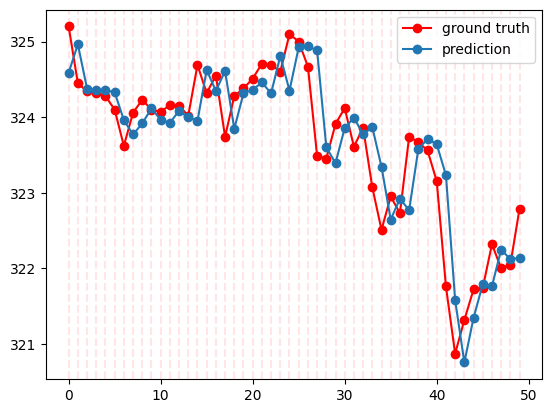

In [808]:
compare(y_test[700:750], y_pred_rf[700:750])

In [409]:
start = 450
end = 500

In [809]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, \
    BayesianRidge, ARDRegression, PassiveAggressiveRegressor, RANSACRegressor, \
    HuberRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


# create a list of regression algorithms to use
regressors = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), Lars(), LassoLars(), OrthogonalMatchingPursuit(),
              BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(), RANSACRegressor(),
              HuberRegressor(), TheilSenRegressor(), XGBRegressor(), DecisionTreeRegressor(), ExtraTreeRegressor(),
              RandomForestRegressor(), ExtraTreesRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), 
              BaggingRegressor(), HistGradientBoostingRegressor(),
              KNeighborsRegressor(), RadiusNeighborsRegressor(), SVR(), NuSVR(), LinearSVR(),
              MLPRegressor(), GaussianProcessRegressor(), KernelRidge()]

# perform regression and print the MSE for each algorithm
for reg in regressors:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    compare(y_test[start:end], y_pred[start:end])
    print(reg.__class__.__name__, "MSE:", mse)

In [810]:
for reg in regressors:
    params = reg.get_params()
    print(reg.__class__.__name__, params)

LSTM

In [754]:
import pandas as pd
from alpaca_trade_api.rest import REST, TimeFrame
# Retrieve the historical bar data for AAPL during regular trading hours. exclude aftermarket data.

# Replace with your own API credentials
API_KEY = 'PKYLYX8BR5Z6F0TIMX92'
API_SECRET = 'ZWHycpjUN02eJw4bcx8dZvOAHnwY2gsUcUtEpTRX'
BASE_URL = 'https://api.alpaca.markets'

# Create an instance of the REST API
api = REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

interval = '15Min' # "1Min", "5Min", "15Min", "1H", "1D", "1W"
start = "2021-01-01"  # start time, min="2015-01-01"
end = "2021-06-08"  # End time, max=today's date
symbol = ['AAPL'] # symbols should trade in ET 

# Check if symbol trades in ET
pass

df = api.get_bars(symbol, interval, start, end, adjustment='raw').df

In [811]:
# Only keep the price info
# df = df.loc[:, 'open':'close']

#only keep numeric columns
df = df.select_dtypes(include=np.number)
df.dropna(inplace=True)

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
labels_train, labels_test = df_train['close'], df_test['close']

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)

In [812]:
def create_sequences(data, labels, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length]
        y = labels[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [833]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau


seq_length = 10 # Change this to the desired sequence length
X_train, y_train = create_sequences(X_train, labels_train, seq_length)
X_test, y_test = create_sequences(X_test, labels_test, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

/tmp/ipykernel_532/576153702.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(xs), np.array(ys)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (67766,) + inhomogeneous part.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        predictions = self.fc(hidden[-1])
        return predictions

In [ ]:
input_size = len(X_train[0][0])
print(input_size)

4


In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [837]:
model = LSTM(input_size=input_size, hidden_size=10, num_layers=2, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
steps = 2000
criterion = nn.MSELoss()

try:
    model.load_state_dict(torch.load('lstm_state_dict.pth'))
    output_test = model(X_test)
    loss_best = criterion(output_test, y_test.view(-1, 1))
except:
    loss_best = float('inf')
    print('could not load model params')
    pass
prev_lr = None
for epoch in range(steps):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        output_test = model(X_test)
        loss_test = criterion(output_test, y_test.view(-1, 1))
        loss_train = criterion(output, y_train.view(-1, 1))
        if loss_test < loss_best:
            loss_best = loss_test
            torch.save(model.state_dict(), 'lstm_state_dict.pth')
        print(f"Epoch {epoch}, loss_train: {loss.item():>5.6f},\
               loss_test: {loss_test.item():>5.6f},\
               loss_best: {loss_best.item():>5.6f}")
        scheduler.step(loss_test)
        lr = optimizer.param_groups[0]['lr']
        if prev_lr and lr != prev_lr:
            print('learning rate damped. Loading best model.')
            model.load_state_dict(torch.load('lstm_state_dict.pth'))
        prev_lr = lr
        print(f'Learning rate:, {lr:.6f}')
        print('-'*100)

Epoch 0, loss_train: 787.889099,               loss_test: 4532.433594,               loss_best: 4532.433594
Learning rate:, 0.010000
----------------------------------------------------------------------------------------------------
Epoch 10, loss_train: 748.958008,               loss_test: 4574.273438,               loss_best: 4532.433594
Learning rate:, 0.010000
----------------------------------------------------------------------------------------------------
Epoch 20, loss_train: 665.346436,               loss_test: 4679.072754,               loss_best: 4532.433594
Learning rate:, 0.010000
----------------------------------------------------------------------------------------------------
Epoch 30, loss_train: 547.481323,               loss_test: 4951.859863,               loss_best: 4532.433594
Learning rate:, 0.010000
----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [827]:
model.load_state_dict(torch.load('lstm_state_dict.pth'))
output = model(X_test).squeeze().detach().numpy()

In [828]:
len(y_test)
start = 1050
end = 1100

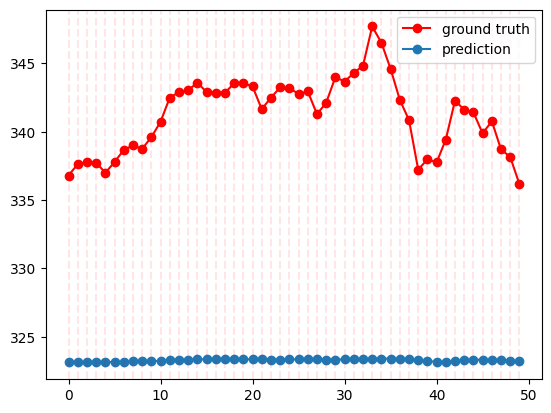

In [829]:
compare(y_test[start:end], output[start:end])